##### **Background:**

We are a small startup focusing mainly on providing machine learning solutions in the European banking market. We work on a variety of problems including fraud detection, sentiment classification and customer intention prediction and classification.

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

##### **Data Description:**

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

**age:** age of customer (numeric)

**job:** type of job (categorical)

**marital:** marital status (categorical)

**education:** (categorical)

**default:** has credit in default? (binary)

**balance:** average yearly balance, in euros (numeric)

**housing:** has a housing loan? (binary)

**loan:** has personal loan? (binary)

**contact:** contact communication type (categorical)

**day:** last contact day of the month (numeric)

**month:** last contact month of year (categorical)

**duration:** last contact duration, in seconds (numeric)

**campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

**y:** has the client subscribed to a term deposit? (binary)

##### **Goal(s):**

Predict if the customer will subscribe (yes/no) to a term deposit (variable y)

##### **Success Metric(s):**

Hit %81 or above accuracy by evaluating with 5-fold cross validation and reporting the average performance score.

##### **Bonus(es):**

We are also interested in finding customers who are more likely to buy the investment product. Determine the segment(s) of customers our client should prioritize.

What makes the customers buy? Tell us which feature we should be focusing more on.

In [1]:
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('term-deposit-marketing-2020.csv', skiprows=1, names=["age", "job", "marital", "education", "default", "balance", "housing", "loan", "contact", "day", "month", "duration", "campaign", "y"])
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,40000.0,40.544600,9.641776,19.0,33.0,39.0,48.0,95.0
balance,40000.0,1274.277550,2903.769716,-8019.0,54.0,407.0,1319.0,102127.0
day,40000.0,16.017225,8.278127,1.0,8.0,17.0,21.0,31.0
duration,40000.0,254.824300,259.366498,0.0,100.0,175.0,313.0,4918.0
campaign,40000.0,2.882175,3.239051,1.0,1.0,2.0,3.0,63.0


In [5]:
binary_features = ['default', 'housing', 'loan', 'y']
df[binary_features] = df[binary_features].apply(lambda x: x.map({'yes': 1, 'no': 0}))

label_encoder = LabelEncoder()
categorical_features = ["job", "marital", "education", "contact", "month"]

for feature in categorical_features:
    df[feature] = label_encoder.fit_transform(df[feature])

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int32
 2   marital    40000 non-null  int32
 3   education  40000 non-null  int32
 4   default    40000 non-null  int64
 5   balance    40000 non-null  int64
 6   housing    40000 non-null  int64
 7   loan       40000 non-null  int64
 8   contact    40000 non-null  int32
 9   day        40000 non-null  int64
 10  month      40000 non-null  int32
 11  duration   40000 non-null  int64
 12  campaign   40000 non-null  int64
 13  y          40000 non-null  int64
dtypes: int32(5), int64(9)
memory usage: 3.5 MB


#### Plotting the correlation matrix

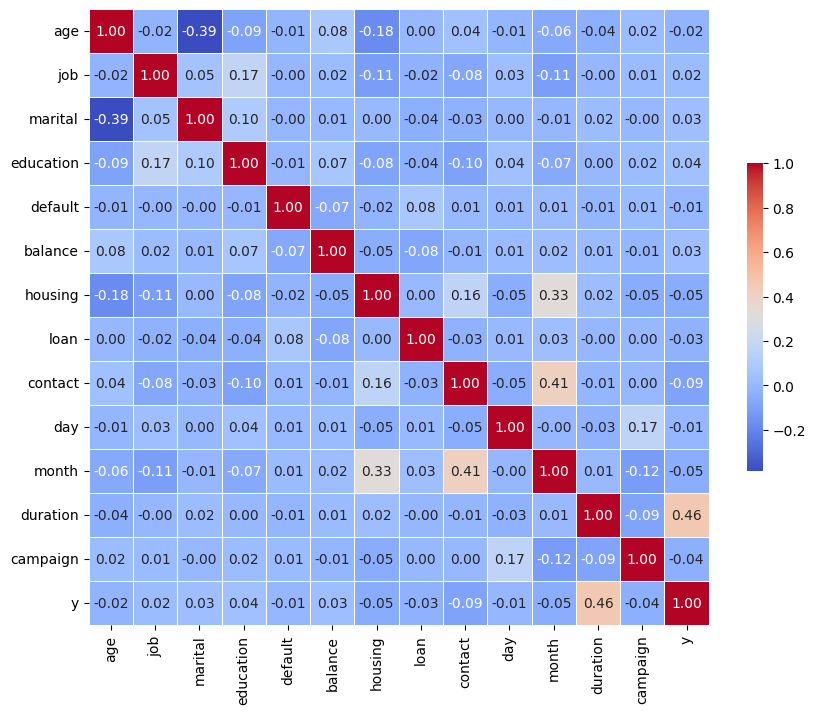

In [8]:
corr = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

##### Heavily imbalanced towards data where customers have not bought the term deposit, I will have to address this later with other techniques

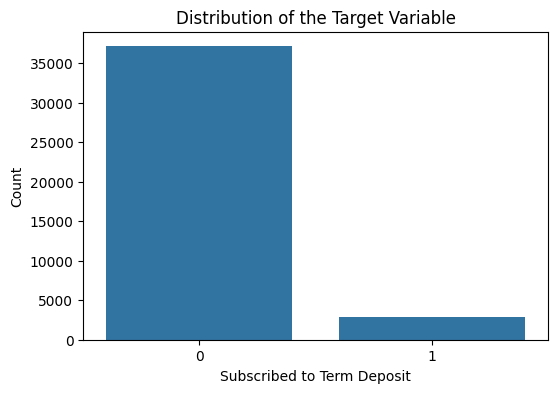

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.title('Distribution of the Target Variable')
plt.show()

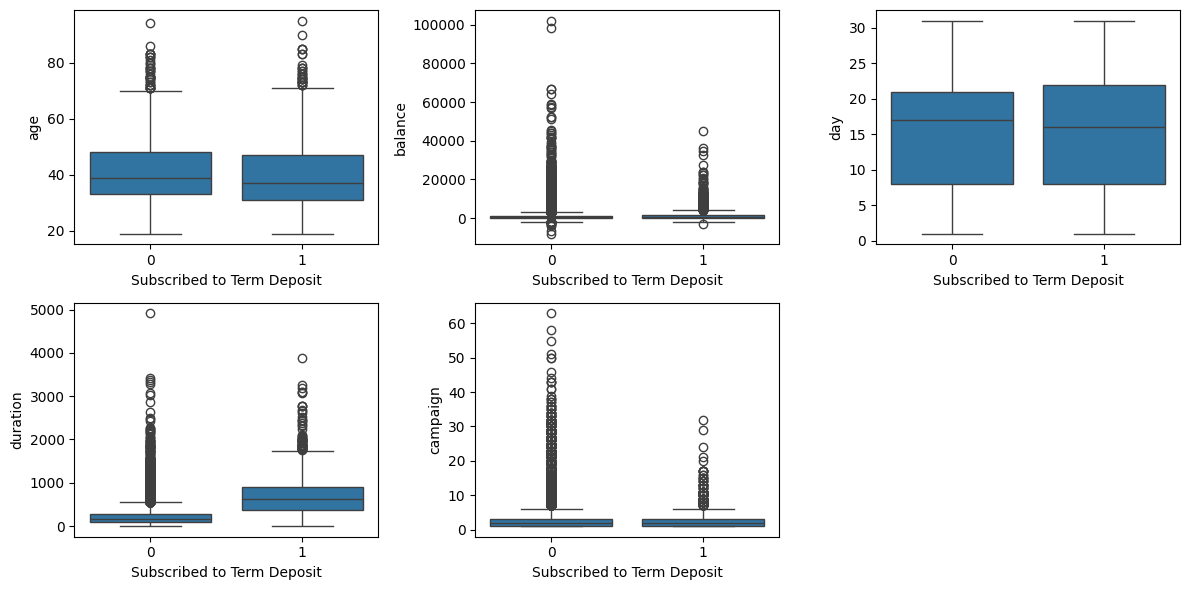

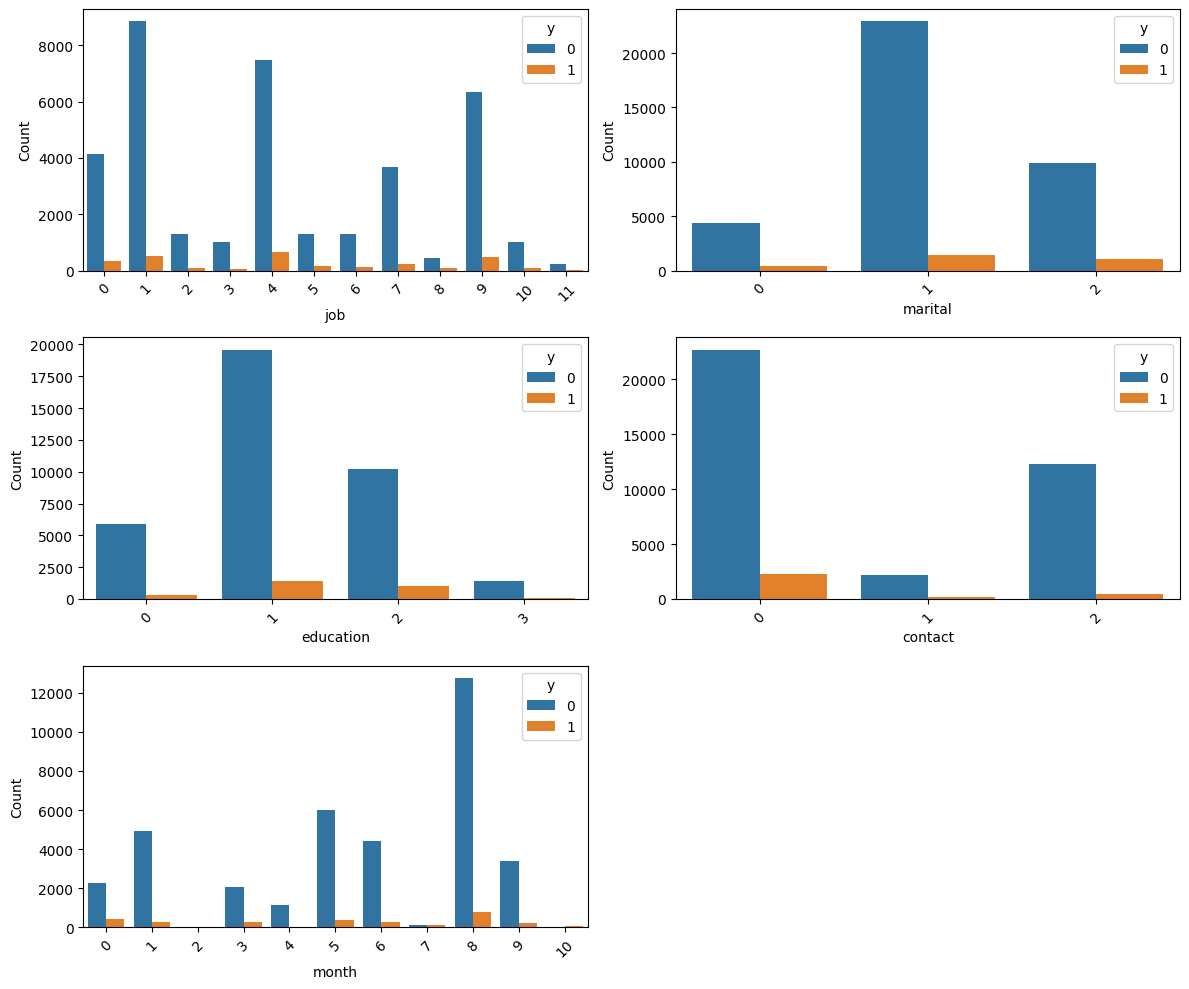

In [10]:
#box plots for numerical features
numerical_features = ["age", "balance", "day", "duration", "campaign"]
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='y', y=feature, data=df)
    plt.xlabel('Subscribed to Term Deposit')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

#bar plots for categorical features
categorical_features = ["job", "marital", "education", "contact", "month"]
plt.figure(figsize=(12, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=feature, hue='y', data=df)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Split the data into train and test data, scale it, then find the scale_pos_weight value to give more importance to class 1 as it is under represented

In [11]:
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


count_class_0 = np.sum(y_train == 0)
count_class_1 = np.sum(y_train == 1)
scale_pos_weight = count_class_0 / count_class_1

##### Create a test XGBoost model to plot feature importances

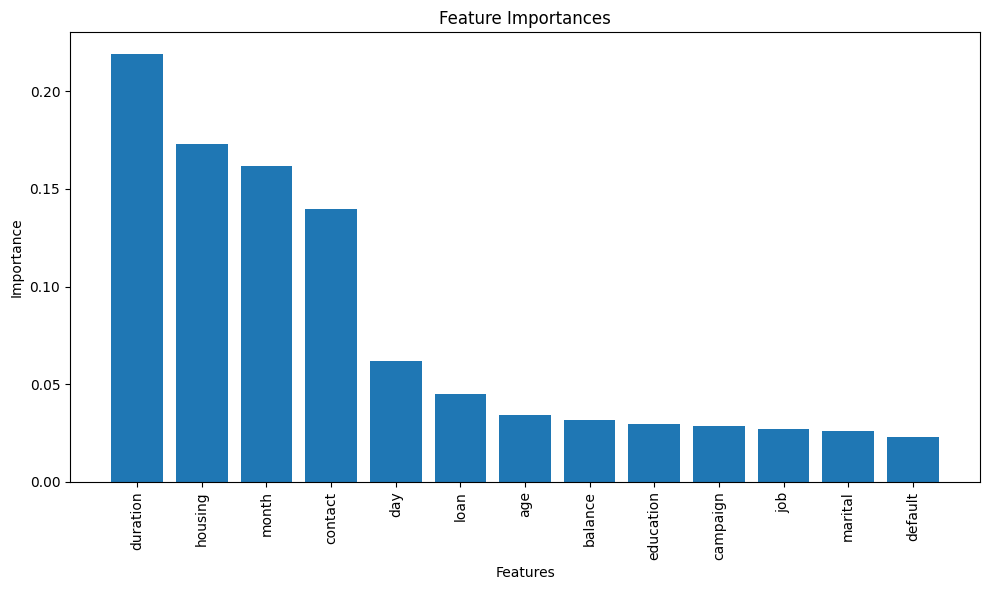

In [12]:
xgb_test = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)

xgb_test.fit(X_train_scaled, y_train)

importances = xgb_test.feature_importances_

feature_names = X.columns

sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances)
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

##### Test with 4 features, Duration, Housing, Month, and Contact

In [13]:
X = df[['duration','housing','month','contact']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

##### Predicting the probability of a data point's class and applying the optimal threshold to balance precision and recall, evaluating the model, then plotting the precision recall curve for predictions on the **training set**

Train Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94     29683
           1       0.41      0.91      0.57      2317

    accuracy                           0.90     32000
   macro avg       0.70      0.90      0.76     32000
weighted avg       0.95      0.90      0.92     32000



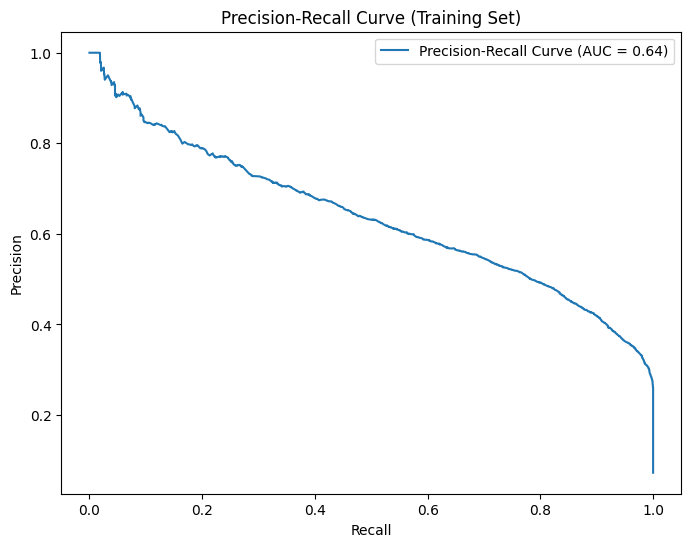

In [14]:
y_pred_prob_train = xgb_model.predict_proba(X_train_scaled)[:, 1]
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_pred_prob_train)
optimal_threshold_train = thresholds_train[np.argmax(precision_train + recall_train)]
y_pred_train = (y_pred_prob_train >= optimal_threshold_train).astype(int)
auc_score_train = auc(recall_train, precision_train)

print("Train Classification Report:\n", classification_report(y_train, y_pred_train))\
plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Precision-Recall Curve (AUC = {auc_score_train:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Training Set)')
plt.legend()
plt.show()

##### Predicting the probability of a data point's class and applying the optimal threshold to balance precision and recall, evaluating the model, then plotting the precision recall curve for predictions on the **Test set**

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.94      7421
           1       0.37      0.82      0.51       579

    accuracy                           0.89      8000
   macro avg       0.68      0.85      0.72      8000
weighted avg       0.94      0.89      0.91      8000



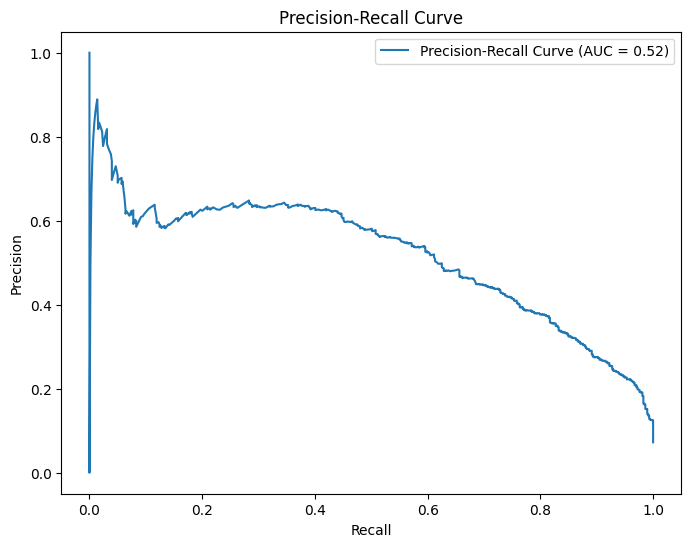

In [15]:
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
optimal_threshold = thresholds[np.argmax(precision + recall)]
y_pred_test = (y_pred_prob >= optimal_threshold).astype(int)
auc_score = auc(recall, precision)

print("Test Classification Report:\n", classification_report(y_test, y_pred_test))
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

##### **Conclusion:**

The XGBoostClassifier was able to successfully achieve the minimum 81% accuracy goal on the test set. Although based on the nature of the problem, the dataset was highly imbalanced and required further optimizations to improve both the precision and recall for the minority class represented. Once optimized, the XGBoost model was able to maintain an 89% accuracy on the test set, while optimizing for precision and recall. To better improve the model, I would recommend gathering more data on the minority class, being customers who bought the Term Deposit. By doing so, a more robust machine learning model may be made to further improve the precision and recall of the model, which would better improve this model's effectiveness to predict a customer's willingness to buy a term deposit. Based on the data analysis and the model, the best predictors for this are the last communication duration in seconds, the last month of contact with the customer, and if the customer has a housing loan.